In [1]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
import skimage
import matplotlib.pyplot as plt
import imageio
import pylab
from glob import glob
import sys
import pandas as pd

In [26]:
import site
site.addsitedir('../../ARGUS/')
from ARGUSUtils import *
from ARGUSUtils_Linearization import *

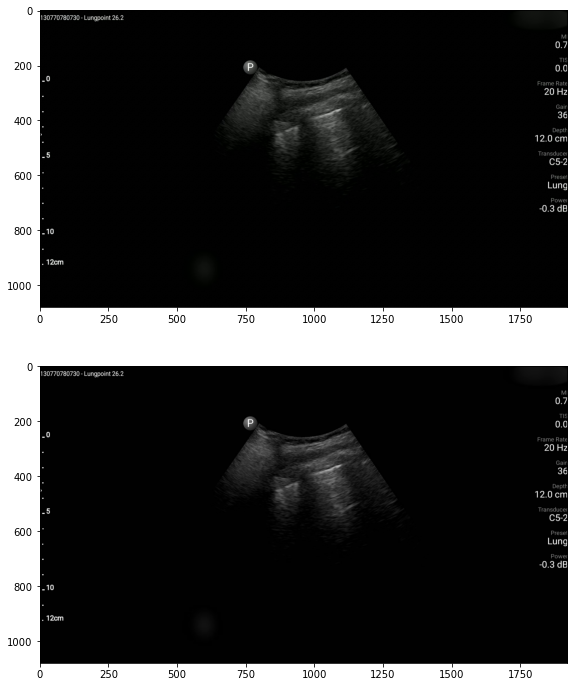

In [21]:
data_paths = sorted(glob("../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding/*.m??"))

ims = np.zeros((2,1080,1920,3))

for i in range(2):
    vid = imageio.get_reader(data_paths[i*2], 'ffmpeg')
    ims[i] = np.copy(vid.get_data(30))
    
ims = ims / 255

fig, axs = plt.subplots(2)
fig.set_size_inches(15,12)

axs[0].imshow(ims[1])

ocimg = np.mean(ims[1], axis=2)
axs[1].imshow(ocimg, cmap = 'gray')
plt.show()

In [22]:
mask = get_mask_from_image(ocimg)

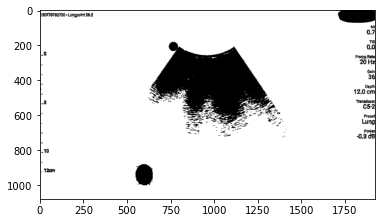

In [25]:
plt.imshow(mask,cmap = 'gray')

In [23]:
img_mapping = get_linear_map_corners(mask, ray_density = 2/3, blur = 0.3)

C:\src\AnatomicRecon-POCUS-AI\ARGUS\ARGUSLinearizationUtils.py:210: RuntimeWarning: invalid value encountered in longlong_scalars
  sl = (bl[1] - tl[1])/(bl[0]-tl[0])
C:\src\AnatomicRecon-POCUS-AI\ARGUS\ARGUSLinearizationUtils.py:211: RuntimeWarning: divide by zero encountered in longlong_scalars
  sr = (br[1] - tr[1])/(br[0]-tr[0])
C:\src\AnatomicRecon-POCUS-AI\ARGUS\ARGUSLinearizationUtils.py:213: RuntimeWarning: invalid value encountered in double_scalars
  center_x = -((-sl* tl[0] + tl[1] + sr *tr[0] - tr[1])/(sl - sr))
C:\src\AnatomicRecon-POCUS-AI\ARGUS\ARGUSLinearizationUtils.py:214: RuntimeWarning: invalid value encountered in double_scalars
  center_y = -((-sl* sr *tl[0] + sr* tl[1] + sl *sr *tr[0] - sl* tr[1])/(sl - sr))


ValueError: cannot convert float NaN to integer

In [6]:
resampled_img = get_resampled_image_from_mapping(ocimg, img_mapping)

In [7]:
from timerit import Timerit

In [20]:
print(np.shape(ocimg))

(360, 640)


In [8]:
t1 = Timerit(num = 1, verbose = 2)
for _ in t1:
    img_mapping = get_rectilinear_resampling_map(mask, ray_density = 2/3, blur = 0.3)

Timed for: 1 loops, best of 1
    time per loop: best=25.674 s, mean=25.674 ± 0.0 s


In [9]:
print(t1.times)

[25.6737445]


In [10]:
t2 = Timerit(num = 10, verbose = 2)
for _ in t2:
    resampled_img = get_resampled_image_from_mapping(ocimg, img_mapping)

Timed for: 10 loops, best of 3
    time per loop: best=751.894 ms, mean=784.015 ± 45.8 ms


In [11]:
print(t2.times)

[0.862926900000005, 0.8279020999999958, 0.7530708999999973, 0.7518941999999953, 0.7565363000000005, 0.7707358999999983, 0.7720665000000011, 0.7685184000000049, 0.789682599999999, 0.8625784999999979]


In [12]:
old_dims = np.asarray(np.shape(ocimg))
new_dims = np.asarray((1080,1920))
zoom = new_dims / old_dims

big_ocimg = sp.ndimage.zoom(ocimg, zoom)

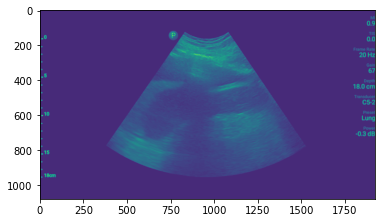

In [13]:
plt.imshow(big_ocimg)

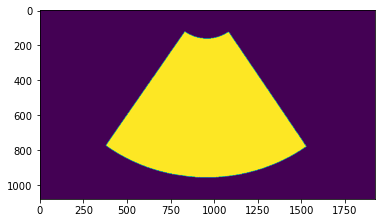

In [14]:
big_mask = get_US_mask_from_image(big_ocimg)
plt.imshow(big_mask)

In [15]:
t3 = Timerit(num = 1, verbose = 2)
for _ in t3:
    big_mask = get_US_mask_from_image(big_ocimg)
    big_img_mapping = get_rectilinear_resampling_map(big_mask, ray_density = 2/3, blur = 0.3)

Timed for: 1 loops, best of 1
    time per loop: best=243.845 s, mean=243.845 ± 0.0 s


In [16]:
t4 = Timerit(num = 10, verbose = 2)
for _ in t4:
    big_resampled_img = get_resampled_image_from_mapping(big_ocimg, big_img_mapping)

Timed for: 10 loops, best of 3
    time per loop: best=8.627 s, mean=8.645 ± 0.0 s


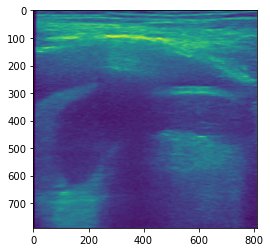

In [17]:
plt.imshow(big_resampled_img)

In [18]:
print(t3.times)

[243.84536029999998]


In [19]:
print(t4.times)

[8.706935499999986, 8.626843800000017, 8.73075879999999, 8.62950189999998, 8.7717892, 8.844505699999957, 8.664377400000035, 8.778998999999999, 8.630458999999973, 8.695146199999954]


In [22]:
from IPython.display import display

In [25]:
timings_df = pd.DataFrame(columns = ["Image Res", "Prep Time (s)", "Avg Exec Time (s)", "Std Dev (s)"])
timings_df.loc[0] = ["360x640", t1.times[0], np.mean(t2.times), np.std(t2.times)]
timings_df.loc[1] = ["1080x1920", t3.times[0], np.mean(t4.times), np.std(t4.times)]
display(timings_df)


,Image Res,Prep Time (s),Avg Exec Time (s),Std Dev (s)
0,360x640,25.673745,0.791591,0.041337
1,1080x1920,243.845360,8.707932,0.070066
